In [1]:
import os

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from gala.mpl_style import laguna, hesperia

from twobody.transforms import PeKi_to_a

from hq.config import Config
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

In [2]:
figure_path = '../../tex/figures'
os.makedirs(figure_path, exist_ok=True)

In [3]:
c = Config.from_run_name('dr16-random')
alldata, allvisit = c.load_alldata()

In [4]:
gold = at.QTable.read('../../catalogs/gold_sample.fits')
bimodal = at.QTable.read('../../catalogs/bimodal.fits')
bimodal = at.QTable(bimodal[bimodal['LOGG'] > -0.5], masked=False)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [5]:
low_mass = gold[(gold['m2_min_50'] < 70*u.Mjup) 
                & (gold['m2_min_50'] > 1*u.Mjup)
                & (gold['MAP_s'] < 1.*u.km/u.s)
                & (gold['n_visits'] > 8)
                & (gold['MAP_e'] < 0.6)]
print(len(low_mass))

high_mass = gold[(gold['m2_min_5'] > gold['mass']*u.Msun)
                 & (gold['MAP_s'] < 1.*u.km/u.s)
                 & (gold['n_visits'] > 5)
                 & (gold['MAP_e'] < 0.6)]
print(len(high_mass))

qmin = gold['m2_min_50'].value / gold['mass']
Rstar = stellar_radius(gold['LOGG'], gold['mass']*u.Msun)
a1sini = PeKi_to_a(gold['MAP_P'], gold['MAP_e'], gold['MAP_K'])
asini = a1sini * (1 + 1/qmin)
rlimit = 0.49*qmin**(-2/3.) / (0.6*qmin**(-2/3.) + np.log(1 + qmin**(-1/3)))
roche = gold[(Rstar/asini).decompose() > rlimit]
print(len(roche))

62
19
16


## Check Troup

In [6]:
troup = at.Table.read('../../data/troup16-dr12.csv')

In [7]:
troup['APOGEE_ID'][:3]

2M00110648+6609349
2M00114326+7112562
2M00225114+6202031


In [8]:
low_mass['APOGEE_ID'][:3].astype(str)

2M03390903+4501021
2M03375988+4543204
2M00505932+8438080


In [9]:
np.isin(low_mass['APOGEE_ID'].astype(str), troup['APOGEE_ID']).sum()

3

In [10]:
np.isin(troup['APOGEE_ID'], gold['APOGEE_ID']).sum()

79

In [11]:
troup_gold = at.join(troup, gold, keys='APOGEE_ID')

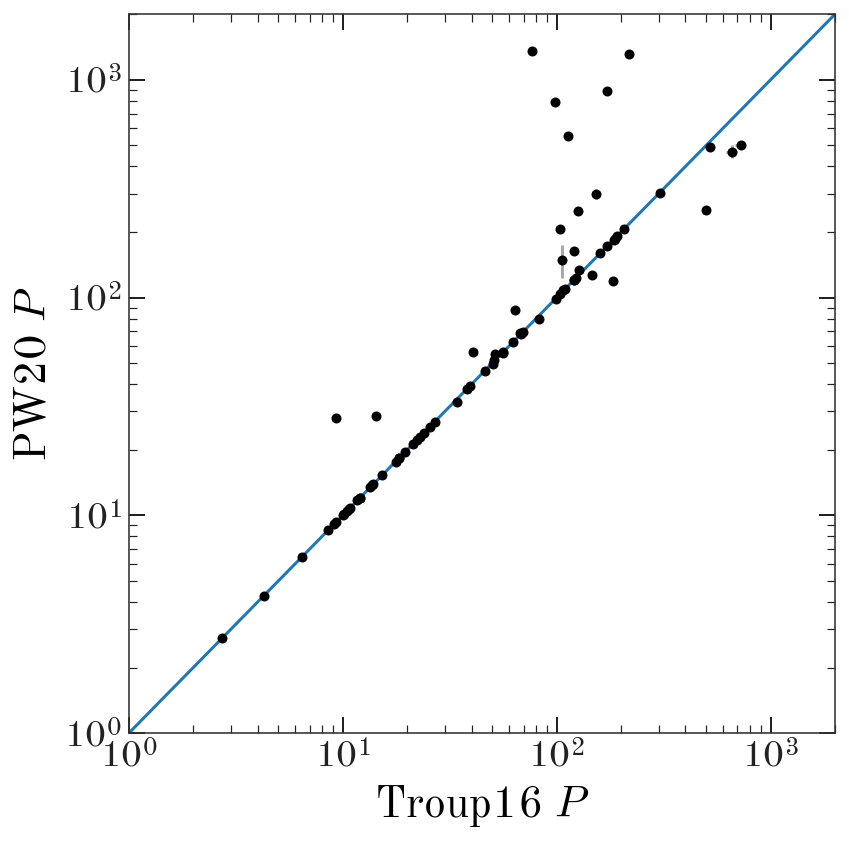

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(troup_gold['PERIOD'], troup_gold['MAP_P'],
          ls='none', marker='o')

ax.errorbar(troup_gold['PERIOD'], troup_gold['MAP_P'].value,
            xerr=troup_gold['PERIOD_ERR'],
            yerr=troup_gold['MAP_P_err'].value,
            ls='none', marker='', ecolor='#aaaaaa')

xxx = np.linspace(1, 1e4, 128)
ax.plot(xxx, xxx, marker='', zorder=-10, color='tab:blue')
ax.set_xlim(1, 2e3)
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('Troup16 $P$')
ax.set_ylabel('PW20 $P$')

fig.tight_layout()

fig.savefig('../../plots/troup_pw_period.png', dpi=250)

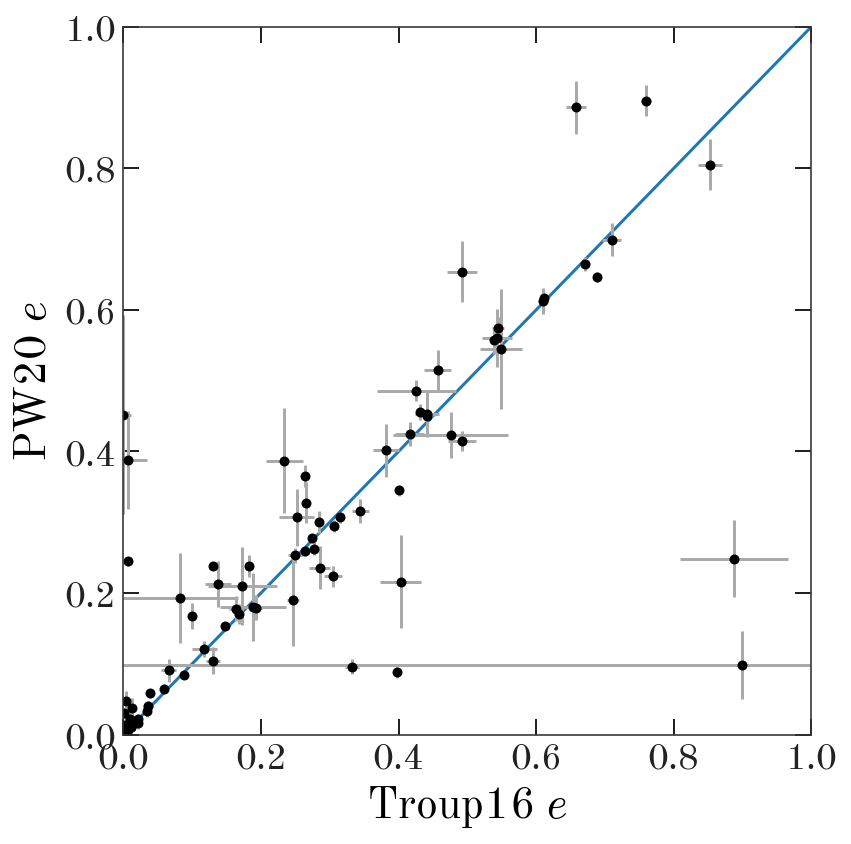

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(troup_gold['ECC'], troup_gold['MAP_e'],
        ls='none', marker='o')

ax.errorbar(troup_gold['ECC'], troup_gold['MAP_e'],
            xerr=troup_gold['ECC_ERR'],
            yerr=troup_gold['MAP_e_err'],
            ls='none', marker='', ecolor='#aaaaaa')

xxx = np.linspace(0, 1, 128)
ax.plot(xxx, xxx, marker='', zorder=-10, color='tab:blue')
ax.set_xlim(0, 1)
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('Troup16 $e$')
ax.set_ylabel('PW20 $e$')

fig.tight_layout()

fig.savefig('../../plots/troup_pw_ecc.png', dpi=250)

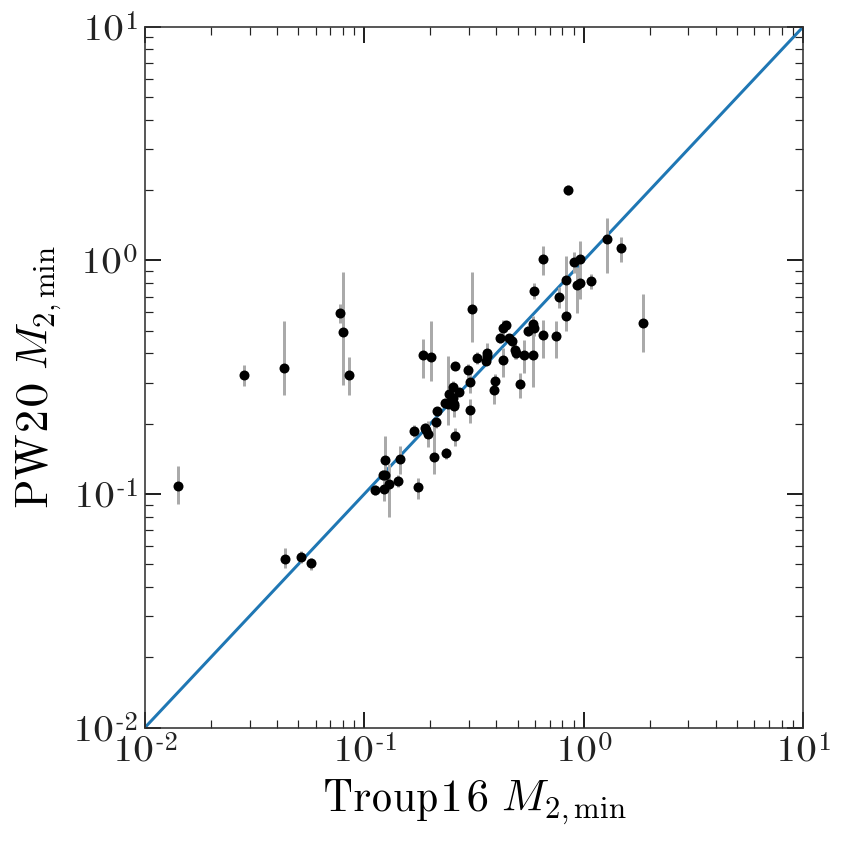

In [14]:
m2_min_err = np.stack((troup_gold['m2_min_50'] - troup_gold['m2_min_16'],
                       troup_gold['m2_min_84'] - troup_gold['m2_min_50'])).T.value

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(troup_gold['MSINI'], troup_gold['m2_min_50'],
          ls='none', marker='o')
ax.errorbar(troup_gold['MSINI'], troup_gold['m2_min_50'].value,
            yerr=m2_min_err.T,
            ls='none', marker='', ecolor='#aaaaaa')
xxx = np.logspace(-2, 1, 128)
ax.plot(xxx, xxx, marker='', zorder=-10, color='tab:blue')
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(ax.get_xlim())

ax.set_xlabel(r'Troup16 $M_{2,{\rm min}}$')
ax.set_ylabel(r'PW20 $M_{2,{\rm min}}$')

fig.tight_layout()

fig.savefig('../../plots/troup_pw_mass.png', dpi=250)

In [15]:
len(troup), len(troup_gold)

(382, 79)

In [16]:
PW20_binaries = at.QTable.read('../../catalogs/lnK0.0_logL4.6_metadata.fits')
troup_PW20 = at.join(troup, PW20_binaries, keys='APOGEE_ID')
len(troup_PW20)

227

## Low Mass filtering:

In [17]:
# for row in low_mass[np.argsort(low_mass['m2_min_50'])][40:]:
#     apid = row['APOGEE_ID']
#     with h5py.File(c.mcmc_results_path, 'r') as f:
#         samples = tj.JokerSamples.read(f[apid])
#         data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
        
#         # fig, ax = plt.subplots()
#         # _ = tj.plot_rv_curves(samples[:16], data=data, ax=ax)
                
#         fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        
#         _ = tj.plot_rv_curves(samples[:128], data=data, ax=axes[0])
        
#         sample = samples.median()
#         _ = tj.plot_phase_fold(sample, ax=axes[1], data=data)
#         axes[0].set_title(f"{row['m2_min_50'].to(u.Mjup):.2f}: {apid}",
#                           fontsize=15)
#         axes[1].set_ylabel('')
#         fig.tight_layout()
#         print(apid)

In [18]:
low_mass_fav_ids = [
    '2M04394882-7514363',
    '2M13500861+3249553',
    '2M01083937+8550346',
    '2M17142443-2457219'
]

## High mass filtering

In [19]:
# for row in high_mass[np.argsort(high_mass['m2_min_50'])]:
#     apid = row['APOGEE_ID']
#     with h5py.File(c.mcmc_results_path, 'r') as f:
#         samples = tj.JokerSamples.read(f[apid])
#         data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
                
#         fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        
#         _ = tj.plot_rv_curves(samples[:128], data=data, ax=axes[0])
        
#         sample = samples.median()
#         _ = tj.plot_phase_fold(sample, ax=axes[1], data=data)
#         axes[0].set_title(f"{row['m2_min_50'].to(u.Msun):.2f}: {apid}",
#                           fontsize=15)
#         axes[1].set_ylabel('')
#         fig.tight_layout()
#         print(apid)

In [20]:
high_mass_fav_ids = [
    '2M13090983+1711572',
    '2M14332948+0958420',
    '2M13143277+1702017',
    '2M00574795+8502290'
]

---

In [22]:
def make_figure(ids, mass_unit, title):
    mass_unit_str = f'{mass_unit:latex_inline}'[1:-1]
    
    fig, axes = plt.subplots(4, 2, figsize=(8., 9), 
                             sharey='row',
                             constrained_layout=True)

    for n, apid in enumerate(ids):
        row = gold[gold['APOGEE_ID'] == apid][0]
        with h5py.File(c.mcmc_results_path, 'r') as f:
            samples = tj.JokerSamples.read(f[apid])
            data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
            MAP_sample = samples[samples['ln_likelihood'].argmax()]

            dt = (data.t.max() - data.t.min()).jd
            step = np.mean(samples['P'].value / 256)
            t_grid = data.t0 + np.arange(-0.1 * dt, 1.1 * dt+1e-6, step) * u.day

            data = tj.RVData(t=data.t, rv=data.rv - MAP_sample['v0'], 
                             rv_err=data.rv_err)
            samples['v0'] = samples['v0'] - MAP_sample['v0']

            ax = axes[n, 0]
            _ = tj.plot_rv_curves(samples, data=data, ax=ax, 
                                  add_labels=False, t_grid=t_grid,
                                  plot_kwargs=dict(color='tab:blue', 
                                                   rasterized=True,
                                                   zorder=-10), 
                                  data_plot_kwargs=dict(markersize=3),
                                  relative_to_t0=True)
            ax.set_rasterization_zorder(0)

            ax.set_ylabel(f'$v_n - v_0$ [{u.km/u.s:latex_inline}]',
                          fontsize=14)
            ylim = ax.get_ylim()
            yptp = ylim[1] - ylim[0]
            ylim = (-0.65 * yptp, 0.65 * yptp)
            yptp = ylim[1] - ylim[0]
            if yptp < 4:
                lim = np.round(ylim[1])
                step = 1
                step_minor = 1
            elif yptp < 20:
                lim = np.ceil(ylim[1] / 2.) * 2
                step = 2
                step_minor = 1
            elif yptp < 200:
                lim = np.ceil(ylim[1] / 50.) * 50
                step = 50
                step_minor = 25
            else:
                lim = np.ceil(ylim[1] / 100.) * 100
                step = 100
                step_minor = 50

            ax.set_yticks(np.arange(-lim, lim, step))
            ax.set_yticks(np.arange(-lim, lim, step_minor), minor=True)
            ax.set_ylim(ylim)

            xlim = ax.get_xlim()
            xptp = xlim[1] - xlim[0]
            ax.set_xticks(np.arange(-100, xlim[1], 100), minor=True)
            ax.set_xlim(xlim)

            ax.text(xlim[0] + xptp*0.04,
                    ylim[1] - yptp*0.04,
                    f'{apid}',
                    ha='left', va='top',
                    fontsize=10, color='#222222',
                    bbox=dict(facecolor='w', alpha=0.5))
            
            ax.text(xlim[1] - xptp*0.04,
                    ylim[1] - yptp*0.04,
                    ('$P = {:.1f}'.format(MAP_sample['P'].to_value(u.day)) 
                     + r'\,{\rm d}$'
                     + '\n$e = {:.1f}$'.format(MAP_sample['e'])),
                    ha='right', va='top',
                    fontsize=10, color='#222222',
                    bbox=dict(facecolor='w', alpha=0.5))

            # ---

            ax = axes[n, 1]
            _ = tj.plot_phase_fold(MAP_sample, ax=ax, data=data, 
                                   add_labels=False,
                                   plot_kwargs=dict(color='tab:blue', 
                                                    rasterized=True), 
                                   data_plot_kwargs=dict(markersize=3))

            ax.set_xticks(np.arange(0, 1+1e-3, 0.25))
            ax.set_xticklabels(['' for i in range(len(ax.get_xticks()))])

            xlim = ax.get_xlim()
            xptp = xlim[1] - xlim[0]

            ylim = ax.get_ylim()
            yptp = ylim[1] - ylim[0]

            err1 = row['m2_min_50'] - row['m2_min_16']
            err2 = row['m2_min_84'] - row['m2_min_50']
            mass_text = (f"{row['m2_min_50'].to_value(mass_unit):.1f}" 
                         + "^{{+{:.1f}}}_{{-{:.1f}}}\,{}$"
                         .format(err1.to_value(mass_unit), 
                                 err2.to_value(mass_unit),
                                 mass_unit_str))
            ax.text(xlim[0] + xptp*0.04,
                    ylim[1] - yptp*0.03,
                    r'$M_{2, {\rm min}} = ' + mass_text,
                    ha='left', va='top',
                    fontsize=12, color='#222222',
                    fontfamily='DejaVu Serif',
                    bbox=dict(facecolor='w', alpha=0.5))

            for ax in axes[n]:
                ax.xaxis.set_ticks_position('bottom')

    axes[0, 0].set_title('Visit Velocities & Orbit Samples', fontsize=16)
    axes[0, 1].set_title('Phase-folded w/ MAP sample', fontsize=16)

    axes[n, 1].set_xticklabels([f'{x:.2f}' for x in axes[n, 1].get_xticks()])
    axes[n, 0].set_xlabel(f'time, $t-t_0$ [{u.day:latex_inline}]', fontsize=16)
    axes[n, 1].set_xlabel(r'phase, $(M-M_0)/(2\pi)$', fontsize=16)

    fig.suptitle(title, fontsize=20)
    
    return fig

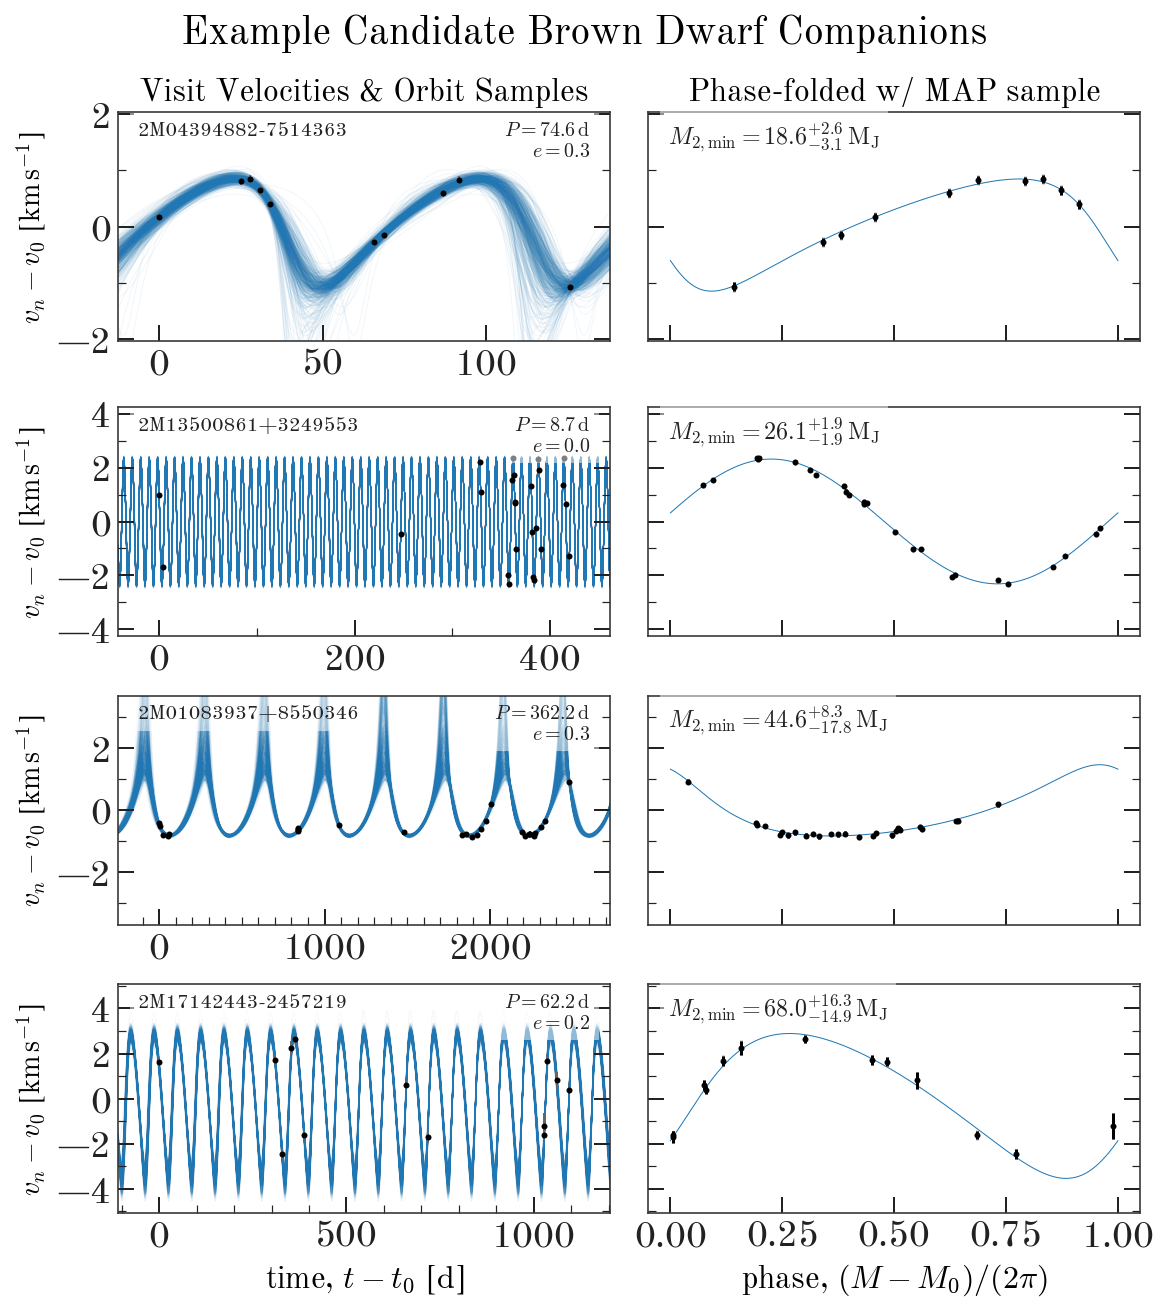

In [23]:
fig = make_figure(low_mass_fav_ids, u.Mjup, 
                  'Example Candidate Brown Dwarf Companions')
fig.savefig(os.path.join(figure_path, 'example-brown-dwarfs.pdf'), dpi=250)
# fig.savefig(os.path.join(figure_path, 'example-brown-dwarfs-placeholder.png'), dpi=200)

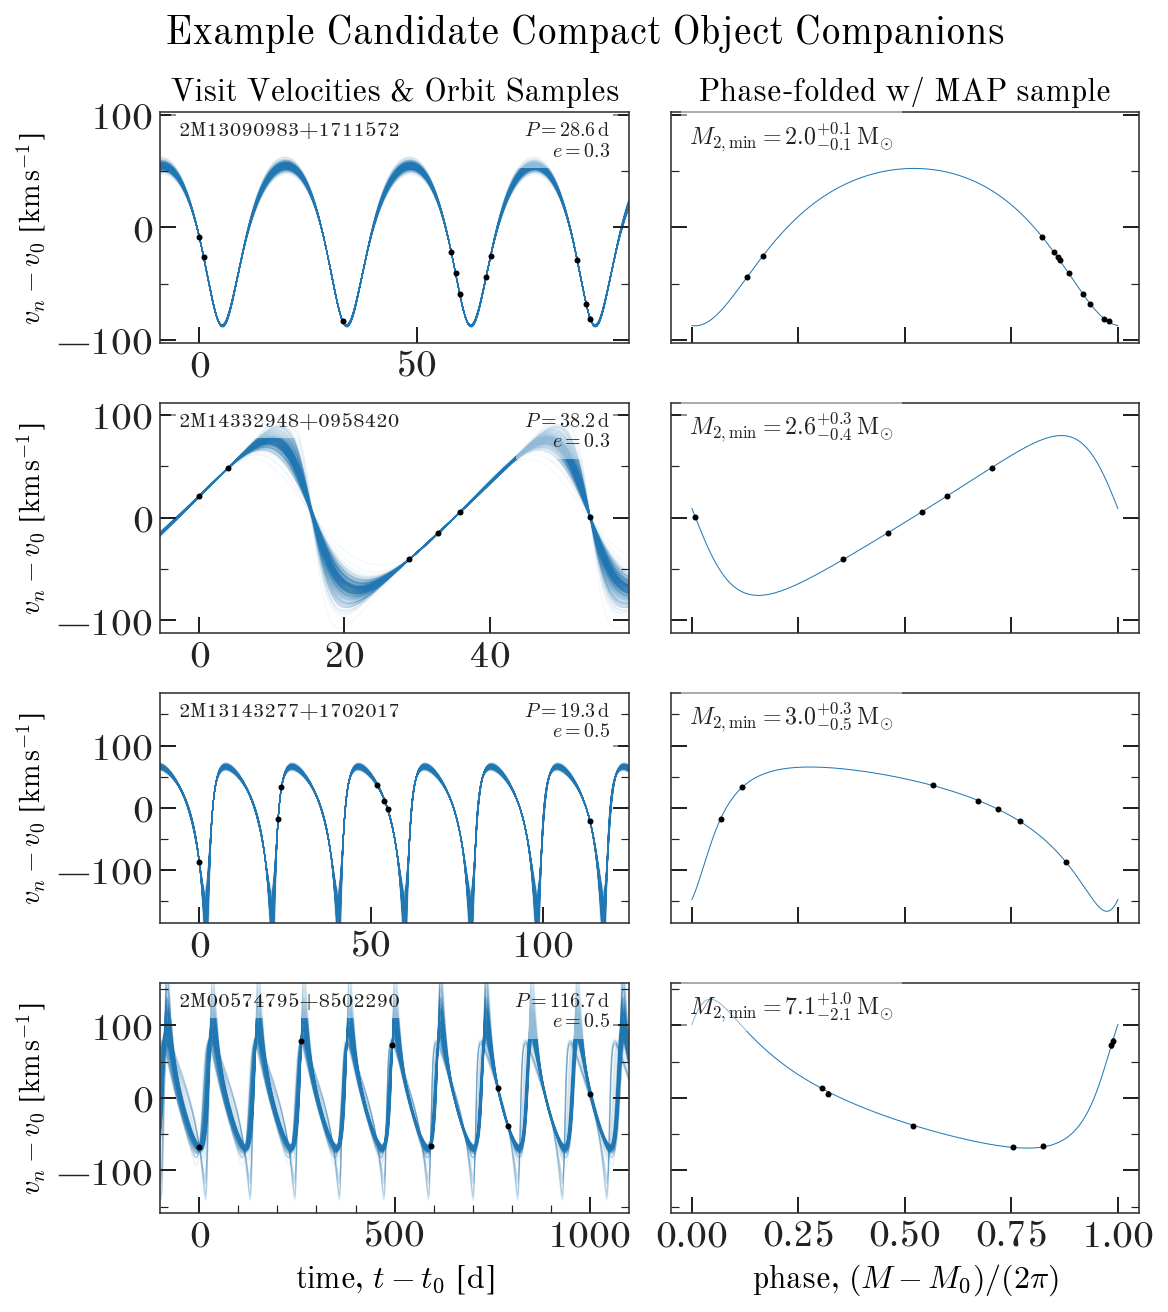

In [24]:
fig = make_figure(high_mass_fav_ids, u.Msun, 
                  'Example Candidate Compact Object Companions')
fig.savefig(os.path.join(figure_path, 'example-compact-objects.pdf'), dpi=250)
# fig.savefig(os.path.join(figure_path, 'example-compact-objects-placeholder.png'), dpi=200)